In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import torch.optim as optim

In [84]:
import glob
import random 
import time

import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets

from torch.autograd import Variable
from torch.utils import data
import torch.nn as nn
import torch.nn.functional as F

In [105]:
class MyRotationTransform:
    """Rotate by one of the given angles."""

    def __init__(self, angles):
        self.angles = angles

    def __call__(self, x):
        angle = random.choice(self.angles)
        return transforms.functional.rotate(x, angle)

In [107]:
transform = transforms.Compose([
    transforms.Pad((0, 50, 0, 50), fill=(35,150,58)),
    MyRotationTransform(angles=[0, 90, 180, 270]),
    transforms.ToTensor()
])

In [108]:
#dataset = datasets.ImageFolder('./rps-cv-images/', transform=transform) # This is all data load at once

In [109]:
train = datasets.ImageFolder('./data/train/', transform=transform)# This is train only
test = datasets.ImageFolder('./data/test/', transform=transform)# This is test only

trainloader = torch.utils.data.DataLoader(train, batch_size=8, shuffle=True)
testloader = torch.utils.data.DataLoader(test, batch_size=8, shuffle=True)

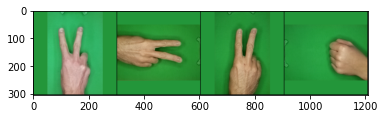

In [110]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

# images = images / 2 + 0.5
npimg = torchvision.utils.make_grid(images[:4]).numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.show()

In [111]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.shortcut = nn.Sequential()

        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [112]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes,
                               kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [113]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.fc = nn.Linear(512*9*9*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [122]:
# These are predefined resnet types
def ResNet18():
    return ResNet(BasicBlock, [2,2,2,2])

def ResNet34():
    return ResNet(BasicBlock, [3,4,6,3])

def ResNet50():
    return ResNet(Bottleneck, [3,4,6,3])

def ResNet101():
    return ResNet(Bottleneck, [3,4,23,3])

def ResNet152():
    return ResNet(Bottleneck, [3,8,36,3])

In [123]:
def resnet_evaluation(net, dataloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the test images: %d %%' % (
        100 * correct / total))

In [124]:
net = ResNet18() # Change this to switch resnet type
torch.cuda.empty_cache()
# net = torch.hub.load('pytorch/vision:v0.9.0','resnet18', pretrained=True)


if torch.cuda.is_available():
    net.cuda()

In [125]:
resnet_evaluation(net, testloader)

Accuracy of the network on the test images: 7 %


In [126]:
num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, 3)
if torch.cuda.is_available():
    net.cuda()

In [127]:
resnet_evaluation(net, testloader)

Accuracy of the network on the test images: 32 %


In [128]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.0001) # 已经调好的参数

for epoch in range(20):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 50 == 49:    # print every 50 mini-batches
            print('[%d, %5d] loss: %.3f' %
                 (epoch + 1, i + 1, running_loss / 50))
            running_loss = 0.0

print('Finished Training')

[1,    50] loss: 1.122
[1,   100] loss: 1.092
[1,   150] loss: 1.070
[1,   200] loss: 1.041
[2,    50] loss: 1.017
[2,   100] loss: 0.966
[2,   150] loss: 0.942
[2,   200] loss: 0.923
[3,    50] loss: 0.928
[3,   100] loss: 0.900
[3,   150] loss: 0.855
[3,   200] loss: 0.860
[4,    50] loss: 0.830
[4,   100] loss: 0.812
[4,   150] loss: 0.814
[4,   200] loss: 0.820
[5,    50] loss: 0.798
[5,   100] loss: 0.768
[5,   150] loss: 0.739
[5,   200] loss: 0.727
[6,    50] loss: 0.704
[6,   100] loss: 0.717
[6,   150] loss: 0.707
[6,   200] loss: 0.719
[7,    50] loss: 0.659
[7,   100] loss: 0.692
[7,   150] loss: 0.667
[7,   200] loss: 0.632
[8,    50] loss: 0.608
[8,   100] loss: 0.625
[8,   150] loss: 0.608
[8,   200] loss: 0.590
[9,    50] loss: 0.576
[9,   100] loss: 0.600
[9,   150] loss: 0.562
[9,   200] loss: 0.578
[10,    50] loss: 0.587
[10,   100] loss: 0.538
[10,   150] loss: 0.527
[10,   200] loss: 0.575
[11,    50] loss: 0.522
[11,   100] loss: 0.506
[11,   150] loss: 0.520
[11,

In [129]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 85 %
